In [1]:
import pandas as pd
import numpy as np
path = '../data/'
import os
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
viz_path = '../viz/'
from utils import *
from network import *
from geo_exploration import *

In [2]:
df = load_data(path)
df = preprocess(df)



/Users/caom/Documents/CausalLens_TakeHome/src/utils.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ended_at'] = pd.to_datetime(df['ended_at'], format='ISO8601')
/Users/caom/Documents/CausalLens_TakeHome/src/utils.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year_started'] = df['started_at'].dt.year
/Users/caom/Documents/CausalLens_TakeHome/src/utils.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

In [3]:
df

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,...,hour_started,minute_started,second_started,year_ended,month_ended,day_ended,weekday_ended,hour_ended,minute_ended,second_ended
295082,11AA3AB3ED9FEFC5,classic_bike,2022-01-01 00:10:20,2022-01-01 00:19:29,Riverview Park,JC057,Riverview Park,JC057,40.744319,-74.043991,...,0,10,20,2022,1,1,5,0,19,29
312873,554FD61E00599BE2,electric_bike,2022-01-01 00:10:24,2022-01-01 00:14:06,Sip Ave,JC056,Glenwood Ave,JC094,40.730897,-74.063913,...,0,10,24,2022,1,1,5,0,14,6
312934,4D3D324F756B7103,electric_bike,2022-01-01 00:10:28,2022-01-01 00:14:12,Sip Ave,JC056,Glenwood Ave,JC094,40.730897,-74.063913,...,0,10,28,2022,1,1,5,0,14,12
295511,E26BB19DBC834216,classic_bike,2022-01-01 00:10:30,2022-01-01 00:24:30,Grove St PATH,JC005,Newport Pkwy,JC008,40.719586,-74.043117,...,0,10,30,2022,1,1,5,0,24,30
298413,DC18B042AA415411,classic_bike,2022-01-01 00:11:31,2022-01-01 00:30:43,Columbus Dr at Exchange Pl,JC106,Columbus Dr at Exchange Pl,JC106,40.716870,-74.032810,...,0,11,31,2022,1,1,5,0,30,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49840,B41EB02871B99E34,classic_bike,2024-04-30 23:36:20,2024-04-30 23:38:15,Newark Ave,JC032,Jersey & 6th St,JC027,40.721525,-74.046305,...,23,36,20,2024,4,30,1,23,38,15
39859,AD14D110757EAC72,electric_bike,2024-04-30 23:41:50,2024-04-30 23:46:59,9 St HBLR - Jackson St & 8 St,HB305,Church Sq Park - 5 St & Park Ave,HB601,40.748099,-74.038417,...,23,41,50,2024,4,30,1,23,46,59
40621,CF187C42DFB29698,electric_bike,2024-04-30 23:41:55,2024-04-30 23:47:04,9 St HBLR - Jackson St & 8 St,HB305,Church Sq Park - 5 St & Park Ave,HB601,40.747993,-74.038469,...,23,41,55,2024,4,30,1,23,47,4
48338,D4E42712B36E3DEF,classic_bike,2024-04-30 23:48:53,2024-04-30 23:50:35,Newark Ave,JC032,Van Vorst Park,JC035,40.721525,-74.046305,...,23,48,53,2024,4,30,1,23,50,35


In [4]:

def spatial_demand_extraction(df):
    # Create outgoing bikes data
    outgoing = df.groupby(['start_station_name', 'year_started', 'month_started', 'weekday_started', 'hour_started']).size().reset_index(name='outgoing_bikes')

    # Create incoming bikes data
    incoming = df.groupby(['end_station_name', 'year_ended', 'month_ended', 'weekday_ended', 'hour_ended']).size().reset_index(name='incoming_bikes')
 
    outgoing.rename(columns={'start_station_name': 'station_name', 'year_started': 'year', 'month_started': 'month', 'weekday_started': 'weekday', 'hour_started': 'hour'}, inplace=True)
    incoming.rename(columns={'end_station_name': 'station_name', 'year_ended': 'year', 'month_ended': 'month', 'weekday_ended': 'weekday', 'hour_ended': 'hour'}, inplace=True)

    # Merge the dataframes
    demand = pd.merge(outgoing, incoming, how='outer', on=['station_name', 'year', 'month', 'weekday', 'hour'])
    demand.fillna(0, inplace=True)
    demand['net_bikes'] = demand['incoming_bikes'] - demand['outgoing_bikes']
    
    return demand

def temporal_demand_extraction(df):
    demand = df.groupby(['year_started','month_started','weekday_started','hour_started']).size().reset_index(name='count')
    demand = demand.groupby(['year_started','month_started','weekday_started']).agg({'count': 'max'}).reset_index()
    demand.rename(columns={'year_started': 'year', 'month_started': 'month', 'weekday_started': 'weekday', 'hour_started': 'hour'}, inplace=True)
    return demand
    


Results of Dickey-Fuller Test:
Test Statistic                  -3.167443
p-value                          0.021948
#Lags Used                      15.000000
Number of Observations Used    180.000000
Critical Value (1%)             -3.467211
Critical Value (5%)             -2.877735
Critical Value (10%)            -2.575403
dtype: float64


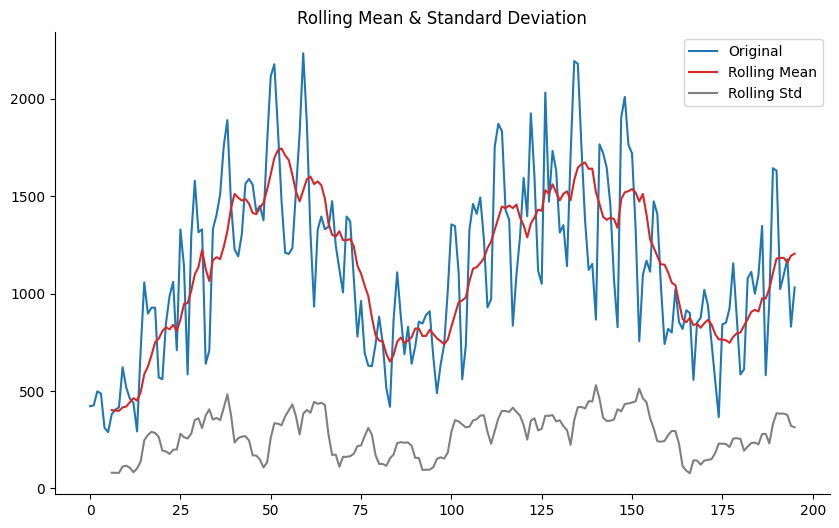

In [5]:
from statsmodels.tsa.stattools import adfuller

# Function to perform the Dickey-Fuller test
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

demand = temporal_demand_extraction(df)

# Perform stationarity test
test_stationarity(demand['count'])

# Plotting rolling statistics:
rolmean = demand['count'].rolling(window=7).mean()  # window can be adjusted
rolstd = demand['count'].rolling(window=7).std()

plt.figure(figsize=(10, 6))
plt.plot(demand['count'], color='Tab:blue', label='Original')
plt.plot(rolmean, color='Tab:red', label='Rolling Mean')
plt.plot(rolstd, color='gray', label='Rolling Std')
plt.legend(loc='best')
sns.despine()
plt.title('Rolling Mean & Standard Deviation')
plt.show()

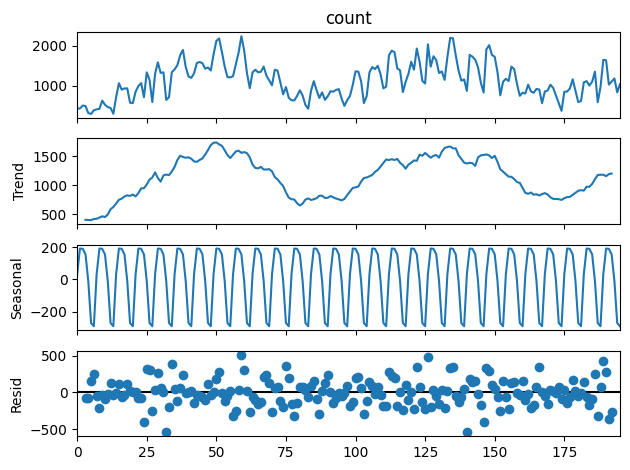

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(demand['count'], model='additive', period=7)  
result.plot()
plt.show()

In [15]:
from tbats import TBATS
import matplotlib.pyplot as plt

demand

# Assuming 'bike_count' is the column with the data you want to model
train_size = int(len(demand) * 0.7)
train, test = demand['count'][:train_size], demand['count'][train_size:]
# Create a TBATS estimator specifying the seasonal periods
# Here you need to know your data's seasonal periods, e.g., 24 hours, 7 days
estimator = TBATS(seasonal_periods=[7, 7*12])

# Fit the model
model = estimator.fit(train)

# Summarize model effects
print(model.summary())

# Forecast future values, e.g., forecast the next 48 hours
tbats_fitted = model.y_hat
tbats_forecasts = model.forecast(steps=len(test))


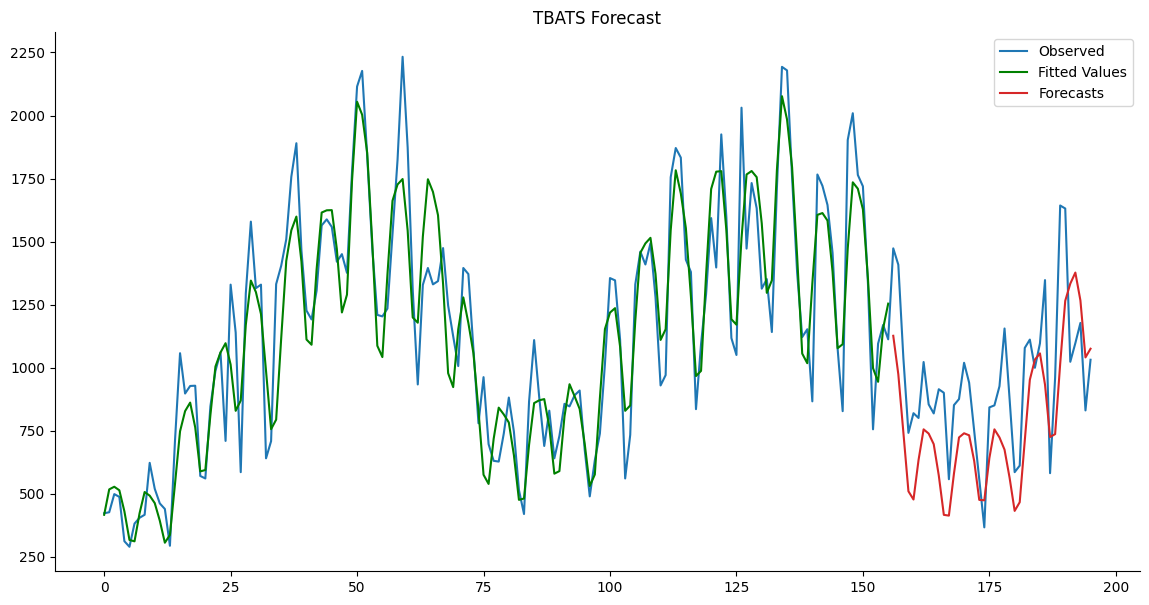

In [ ]:
# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(demand['count'], label='Observed')

fitted_values = model.y_hat
original_index = range(len(train))
forecast_index = range(len(train), len(train) + len(test))

plt.plot(original_index, tbats_fitted, label='Fitted Values', color='green')
plt.plot(forecast_index, tbats_forecasts, label='Forecasts', color='Tab:red')


plt.title('TBATS Forecast')
plt.legend()
sns.despine()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# TBATS metrics
tbats_mae = mean_absolute_error(test, tbats_forecasts)
tbats_rmse = np.sqrt(mean_squared_error(test, tbats_forecasts))
tbats_mape = np.mean(np.abs((test - tbats_forecasts) / test)) * 100

print("TBATS MAE:", tbats_mae)
print("TBATS RMSE:", tbats_rmse)
print("TBATS MAPE:", tbats_mape)

TBATS MAE: 235.36766158998836
TBATS RMSE: 271.405888197068
TBATS MAPE: 24.49188368426254


In [123]:
peak_hourly_demand

2233